In [ ]:
import os
import pandas as pd
import numpy as np
import polars as pl
import pathlib
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from datetime import date, timedelta
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import LinearNDInterpolator
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ms_wind_curtailment_prediction/curtailment_target_features.csv", sep=";", index_col=0)

In [ ]:
df.head()

,redispatch,wind_speed_m/s,wind_direction_degrees,radiation_global_J/m2,air_temperature_K,humidity_percent,wind_gust_max_m/s,wind_direction_gust_max_degrees,forecast_solar_MW,actual_solar_MW,total_grid_load_MWh,residual_load_MWh,pumped_storage_MWh
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,2.1,250.0,0.0,278.45,80.70,3.30,250.0,0.0,0.0,730.95,624.18,3.25
2020-01-01 00:15:00,0.0,2.7,265.0,0.0,278.55,79.95,4.25,265.0,0.0,0.0,727.23,620.78,4.35
2020-01-01 00:30:00,0.0,2.4,240.0,0.0,278.45,80.40,3.50,250.0,0.0,0.0,722.20,611.37,6.40
2020-01-01 00:45:00,0.0,2.7,250.0,0.0,278.55,79.45,3.80,245.0,0.0,0.0,719.22,604.33,8.32
2020-01-01 01:00:00,0.0,2.7,260.0,0.0,278.45,80.50,3.90,260.0,0.0,0.0,717.07,600.83,6.32


In [ ]:
df['redispatch'].value_counts() #class imbalance

0.0    131810
1.0      8398
Name: redispatch, dtype: int64

**Checking for NaN values**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140208 entries, 2020-01-01 00:00:00 to 2023-12-30 23:45:00
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   redispatch                       140208 non-null  float64
 1   wind_speed_m/s                   140192 non-null  float64
 2   wind_direction_degrees           140192 non-null  float64
 3   radiation_global_J/m2            140192 non-null  float64
 4   air_temperature_K                140192 non-null  float64
 5   humidity_percent                 140192 non-null  float64
 6   wind_gust_max_m/s                140192 non-null  float64
 7   wind_direction_gust_max_degrees  140192 non-null  float64
 8   forecast_solar_MW                140096 non-null  float64
 9   actual_solar_MW                  140011 non-null  float64
 10  total_grid_load_MWh              140192 non-null  float64
 11  residual_load_MWh                140192

In [ ]:
df.isnull().sum()

redispatch                           0
wind_speed_m/s                      16
wind_direction_degrees              16
radiation_global_J/m2               16
air_temperature_K                   16
humidity_percent                    16
wind_gust_max_m/s                   16
wind_direction_gust_max_degrees     16
forecast_solar_MW                  112
actual_solar_MW                    197
total_grid_load_MWh                 16
residual_load_MWh                   16
pumped_storage_MWh                  16
dtype: int64

**Forward filling NaN values in actual solar and backward filling NaN values in forecasted solar**

In [ ]:
# Loop through DataFrame rows
for index, row in df.iterrows():
    # Check if column 'forecast_solar_MW' is NaN
    if pd.isna(row['forecast_solar_MW']):
        # If 'forecast_solar_MW' is NaN, fill it with the value from 'actual_solar_MW'
        df.at[index, 'forecast_solar_MW'] = row['actual_solar_MW']

    if pd.isna(row['actual_solar_MW']):
      df.at[index, 'actual_solar_MW'] = row['forecast_solar_MW']


**Using linear interpolation to fill in the rest of the missing values**

In [ ]:
columns_to_interpolate = ["wind_speed_m/s",  "wind_direction_degrees", "humidity_percent", "radiation_global_J/m2", "air_temperature_K", "wind_gust_max_m/s", "wind_direction_gust_max_degrees", "forecast_solar_MW", "actual_solar_MW", "total_grid_load_MWh", "residual_load_MWh", "pumped_storage_MWh"]

# Assuming df is your DataFrame with missing values
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear', limit_direction='both')


If your dataset is large and the missing values are relatively small, it might be reasonable to impute before splitting, as you have enough data to minimize the risk of data leakage.

**Plotting a heatmap of correlations between features**

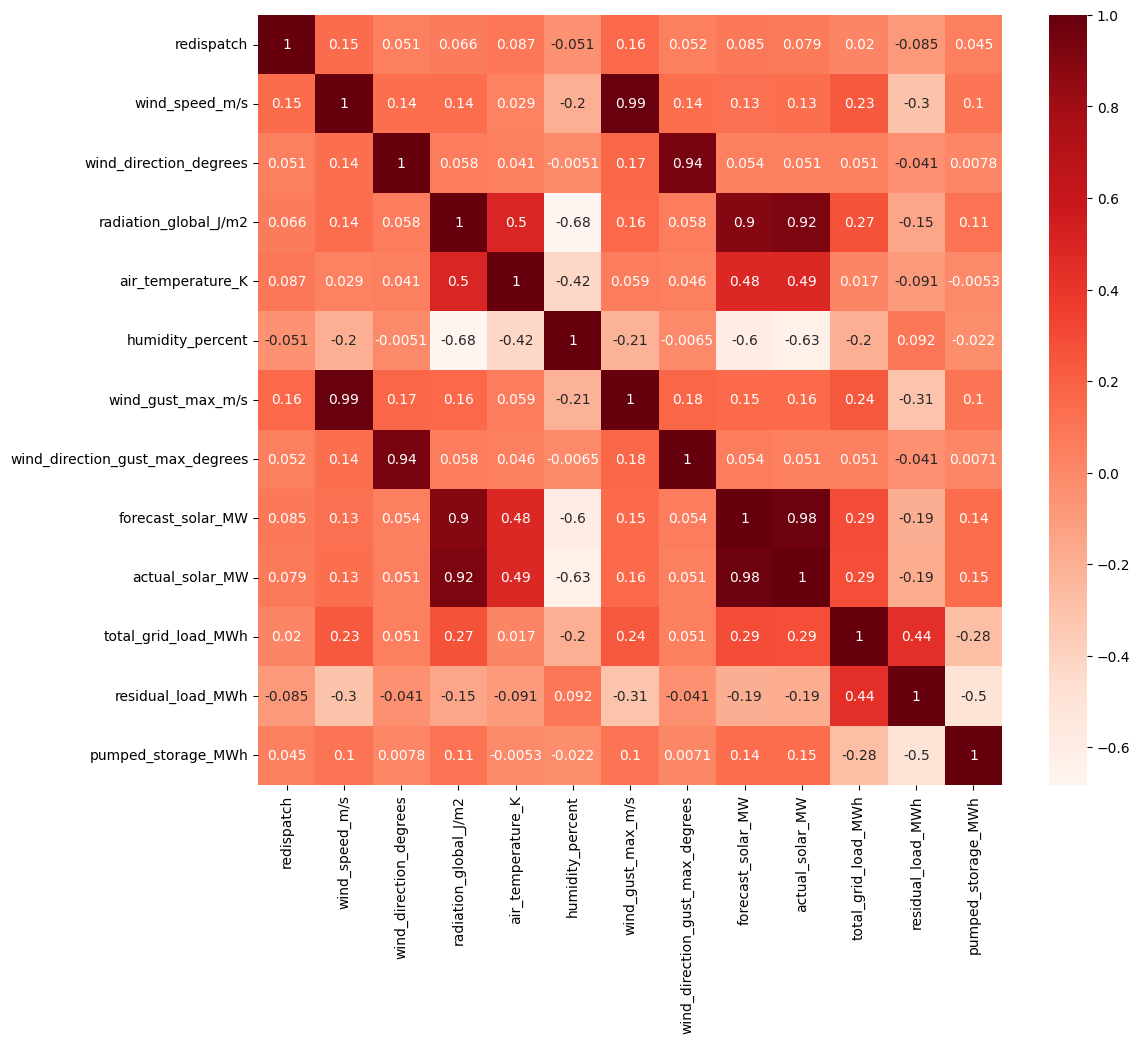

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Checking for features that have a high correlation with the target variable (Redispatch)**

In [ ]:
#Correlation with output variable
print(cor['redispatch'], "\n")
cor_target = abs(cor["redispatch"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

redispatch                         1.000000
wind_speed_m/s                     0.150411
wind_direction_degrees             0.051125
radiation_global_J/m2              0.065840
air_temperature_K                  0.087227
humidity_percent                  -0.051290
wind_gust_max_m/s                  0.159842
wind_direction_gust_max_degrees    0.051660
forecast_solar_MW                  0.084503
actual_solar_MW                    0.078656
total_grid_load_MWh                0.020411
residual_load_MWh                 -0.084978
pumped_storage_MWh                 0.044847
Name: redispatch, dtype: float64 



redispatch    1.0
Name: redispatch, dtype: float64

**Splitting data into target variable and features**

In [ ]:
X = df.drop("redispatch",axis=1)   #Feature Matrix
y = df["redispatch"]          #Target Variable

**Wrapper method of feature selection using Backward elimination and Recursive feature engineering**

In [ ]:
# Split the entire dataset into training and test sets
cutoff_time = "2023-01-01"
train = df[df.index < cutoff_time]
test = df[df.index >= cutoff_time]
X_train = train.drop('redispatch', axis = 1)
y_train = train['redispatch']
X_test = test.drop('redispatch', axis = 1)
y_test = test['redispatch']

# Get column names of X
cols = list(X_train.columns)

# Initialize p-value threshold
pmax = 1

# Perform backward elimination
while len(cols) > 0:
    p = []
    X_1 = X_train[cols]

    # Add constant for logistic regression
    X_1 = sm.add_constant(X_1)

    # Fit logistic regression model
    model = sm.Logit(y_train, X_1).fit()

    # Extract p-values
    p = pd.Series(model.pvalues.values[1:], index=cols)

    # Update pmax
    pmax = max(p)

    # Find feature with the highest p-value
    feature_with_p_max = p.idxmax()

    # Check if pmax is greater than threshold
    if pmax > 0.05:
        # Remove feature with highest p-value
        cols.remove(feature_with_p_max)
    else:
        # Exit loop if pmax is less than or equal to threshold
        break

# Store selected features
selected_features_BE = cols
print(selected_features_BE)


Optimization terminated successfully.
         Current function value: 0.201785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201785
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201791
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201802
         Iterations 8
['wind_speed_m/s', 'radiation_global_J/m2', 'air_temperature_K', 'humidity_percent', 'wind_gust_max_m/s', 'forecast_solar_MW', 'total_grid_load_MWh', 'pumped_storage_MWh']


Backward elimination using logistic regression and pmax gives us the following columns as the feature set

['wind_speed_m/s', 'radiation_global_J/m2', 'air_temperature_K', 'humidity_percent', 'wind_gust_max_m/s', 'forecast_solar_MW', 'total_grid_load_MWh', 'pumped_storage_MWh']



**Feature selection using Recursive Feature Elimination**

---



In [ ]:
# Initialize Logistic Regression model
model = LogisticRegression()

# Initializing RFE model
rfe = RFE(estimator=model, n_features_to_select=7)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X, y)

# Fitting the data to the model
model.fit(X_rfe, y)

print("Support of features:", rfe.support_)
print("Ranking of features:", rfe.ranking_)

# Variable to store the optimum features
nof = 0
high_score = 0

# List of number of features to try
nof_list = np.arange(1, 13)
score_list = []

# Loop through different numbers of features
for n in range(len(nof_list)):

    # Initialize Logistic Regression model
    model = LogisticRegression()

    # Initialize RFE model with current number of features
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])

    # Transform training data using RFE
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    # Transform testing data using RFE
    X_test_rfe = rfe.transform(X_test)

    # Fit the model on the training data
    model.fit(X_train_rfe, y_train)

    # Calculate the score on the testing data
    score = model.score(X_test_rfe, y_test)

    # Append the score to the score list
    score_list.append(score)

    # Update high_score and nof if the current score is higher
    if score > high_score:
        high_score = score
        nof = nof_list[n]

# Print the optimum number of features and the corresponding score
print("Optimum number of features:", nof)
print("Score with %d features: %f" % (nof, high_score))

# Get column names
cols = list(X.columns)

# Initialize Logistic Regression model
model = LogisticRegression()

# Initializing RFE model with 10 features
rfe = RFE(estimator=model, n_features_to_select=10)

# Transform data using RFE
X_rfe = rfe.fit_transform(X, y)

# Fit the data to the model
model.fit(X_rfe, y)

# Get selected features
temp = pd.Series(rfe.support_, index=cols)
selected_features_rfe = temp[temp == True].index

print("Selected features using RFE:", selected_features_rfe)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Support of features: [ True False False  True False  True  True  True  True  True False False]
Ranking of features: [1 3 6 1 5 1 1 1 1 1 4 2]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Optimum number of features: 1
Score with 1 features: 0.928939


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Selected features using RFE: Index(['wind_speed_m/s', 'wind_direction_degrees', 'air_temperature_K',
       'wind_gust_max_m/s', 'wind_direction_gust_max_degrees',
       'forecast_solar_MW', 'actual_solar_MW', 'total_grid_load_MWh',
       'residual_load_MWh', 'pumped_storage_MWh'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
